In [1]:
import tensorflow as tf
import pandas as pd

import nltk
nltk.download('punkt')

from nltk import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacobhansen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
url='https://raw.githubusercontent.com/jacob-hansen/NLP_in_EHR_2022/910d9f0fcfeab083dff53ea2e2969c175cc816a0/train.csv'
train_df = pd.read_csv(url)
# train_df = pd.read_csv('data/train_even.csv')

In [3]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [4]:
def custom_tokenizer(sentence):
    # lower case
    sentence = sentence.lower()
    # split by the label/sentence separator
    sents = sentence.split('. val is ')
    # seperate out the label and the next sentence
    # print(sents)
    new_sents = [sents[0][13:],]
    for sent in sents[1:]:
        new_sents.extend(sents[1].split('. ', 1))
    # print(sents)
    # sents = [sents[0]] + [i for i in sents[1].split('. ')]
    # remove any trailing whitespace
    sents = [i.strip() for i in new_sents]
    
    # remove stop words in every 1,3,5... sentence
    # and apply tokenization
    for i in range(0, len(sents), 2):
        # remove stop words
        sents[i] = [word for word in word_tokenize(sents[i]) if word not in sw_spacy]
    # remove last . from the last sentence
    sents[-1] = sents[-1][:-1]
    
    # flatten sents 
    return_sents = []
    for i in range(len(sents)):
        if i % 2 == 0:
            return_sents.extend(sents[i])
        else:
            return_sents.append(sents[i])
    # repeat the label 3 times (loc = 1,3,5..) for every sentence 
    final_sents = []
    for i in range(0, len(return_sents)):
        if i % 2 == 0:
            final_sents.append(return_sents[i])
        else:
            final_sents.append(return_sents[i])
            final_sents.append(return_sents[i])
            final_sents.append(return_sents[i])

    return return_sents


In [5]:
# apply the custom tokenizer to the dataframe
train_df['tokenized'] = train_df['X_train'].apply(custom_tokenizer)

In [6]:
train_df.iloc[90, 0].lower()

"feature is indicator for prior disabilities that the patient had. mark 1 if any disabilities were noted medically.. val is -0.248.  feature is how long a person is in an unresponsive state after an injury. measured in hours.. val is 0.579.  feature is the amount of time between heart beats measured by ms between heartbeats. . val is 0.33.  feature is concentration of the tau protein in cerebrospinal fluid. measured in pg/ml\n. val is -1.001.  feature is a patient's indication 1-10 of their day to day happiness and satisfaction.. val is -0.535.  feature is how body fat is distributed and how much of someone's body is body fat measured by bmi. range [1-3] where each number is associated to the obesity class that based on which range the bmi falls under. val is -0.191.  feature is how long, in hours, that have passed since the initial injury.. val is -0.176.  feature is how severe the patient's acne appears. 1-10 for the number of pimples or rashes across the face and chest.. val is -0.1

In [7]:
custom_tokenizer(train_df.iloc[90, 0])

['dicator',
 'prior',
 'disabilities',
 'patient',
 '.',
 'mark',
 '1',
 'disabilities',
 'noted',
 'medically',
 '.',
 '-0.248',
 'feature',
 'long',
 'person',
 'unresponsive',
 'state',
 'injury',
 '.',
 'measured',
 'hours',
 '.',
 '-0.248',
 'feature',
 'long',
 'person',
 'unresponsive',
 'state',
 'injury',
 '.',
 'measured',
 'hours',
 '.',
 '-0.248',
 'feature',
 'long',
 'person',
 'unresponsive',
 'state',
 'injury',
 '.',
 'measured',
 'hours',
 '.',
 '-0.248',
 'feature',
 'long',
 'person',
 'unresponsive',
 'state',
 'injury',
 '.',
 'measured',
 'hours',
 '.',
 '-0.248',
 'feature',
 'long',
 'person',
 'unresponsive',
 'state',
 'injury',
 '.',
 'measured',
 'hours',
 '.',
 '-0.248',
 'feature',
 'long',
 'person',
 'unresponsive',
 'state',
 'injury',
 '.',
 'measured',
 'hours',
 '.',
 '-0.248',
 'feature',
 'long',
 'person',
 'unresponsive',
 'state',
 'injury',
 '.',
 'measured',
 'hours',
 '.',
 '-0.248',
 'feature',
 'long',
 'person',
 'unresponsive',
 'state',

In [8]:
# rename columns to X_train, y_train, and tokenized
# train_df = train_df.rename(columns={'0': 'X_train', '1': 'y_train', 'tokenized': 'tokenized'})
# train_df.head()

# Training RNN

In [9]:
# import packages for training RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

In [10]:
target = train_df['y_train'].values
target = to_categorical(target)
# convert train_df['tokenized'] to a tensor
# and pad the sequences to be the same length
max_len = 200
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['tokenized'].values)
X = tokenizer.texts_to_sequences(train_df['tokenized'].values)
X = pad_sequences(X, maxlen=max_len)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2)

In [12]:
# create RNN model 
model = Sequential()
model.add(Embedding(10000, 128, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-11-27 11:55:23.712628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# train model
epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/10
113/113 [==============================] - 43s 355ms/step - loss: 0.5247 - accuracy: 0.7942 - val_loss: 0.4892 - val_accuracy: 0.8087
Epoch 2/10
113/113 [==============================] - 43s 378ms/step - loss: 0.5060 - accuracy: 0.7971 - val_loss: 0.4923 - val_accuracy: 0.8087
Epoch 3/10
113/113 [==============================] - 39s 347ms/step - loss: 0.5015 - accuracy: 0.7971 - val_loss: 0.4868 - val_accuracy: 0.8087
Epoch 4/10
113/113 [==============================] - 37s 331ms/step - loss: 0.4785 - accuracy: 0.7986 - val_loss: 0.4849 - val_accuracy: 0.8037
Epoch 5/10
113/113 [==============================] - 39s 348ms/step - loss: 0.3877 - accuracy: 0.8299 - val_loss: 0.5688 - val_accuracy: 0.7625
Epoch 6/10
113/113 [==============================] - 40s 351ms/step - loss: 0.3356 - accuracy: 0.8485 - val_loss: 0.5676 - val_accuracy: 0.7675
Epoch 7/10
113/113 [==============================] - 38s 338ms/step - loss: 0.3272 - accuracy: 0.8429 - val_loss: 0.6060 - val_ac

In [14]:
# test the model
score, acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 64)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

32/32 - 3s - loss: 0.8524 - accuracy: 0.7810 - 3s/epoch - 82ms/step
score: 0.85
acc: 0.78


In [35]:
# find predictions for the test set
y_pred = model.predict(X_test)
print(y_pred)

63/63 [==============================] - 3s 42ms/step
[[2.0313883e-02 9.7968608e-01]
 [9.9991155e-01 8.8487781e-05]
 [7.8403789e-01 2.1596207e-01]
 ...
 [6.5342575e-01 3.4657425e-01]
 [8.2341468e-01 1.7658535e-01]
 [9.9845254e-01 1.5473857e-03]]


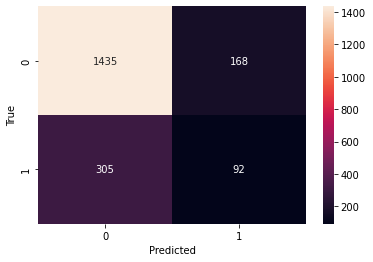

In [40]:
# calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_pred = np.argmax(y_pred, axis=1)
# y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
# add labels 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [41]:
# calculate f1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='macro')


0.5692856014362003

In [42]:
# calculate f1 score on random shuffle of y_pred
from sklearn.utils import shuffle
y_pred_shuffled = shuffle(y_pred)
f1_score(y_test, y_pred_shuffled, average='macro')

0.4891526900754934